## libraries and function 

In [ ]:
!pip install impyute
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
import numpy as np
import impyute as impy
from fancyimpute import IterativeSVD, SoftImpute, NuclearNormMinimization
import pandas as pd
import time

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


The function `mle` allows us to compute the MLEs from training data with monotone missing data.

We denote
$$n = \begin{pmatrix}
n_1^{(1)} & n_1^{(2)} &...&n_1^{(K)}\\
\vdots & \vdots &\ddots&\vdots\\
n_G^{(1)} & n_G^{(2)} &...&n_G^{(K)}
\end{pmatrix}$$
$$p = (p_1,p_2,...,p_K)$$
G is the number of classes.

If we let $\mu = (\mu^{(1)}, ..., \mu^{(G)})$ and $\bar{x}_i = (\bar{x}_i^{(1)},...,\bar{x}_i^{(G)})$ then we see that the update rule for mu becomes

$$\hat{\mu}= \begin{pmatrix}\hat{\mu}\\
[\bar{x}_i]_2 - P_i([\bar{x}_i]_1-\hat{\mu})
\end{pmatrix}$$

### MLE function 

In [ ]:
import numpy as np
def mle(Xtrain, n, p, G):
    '''
    Xtrain: list of input. The ith element of the list contains the sample from
    the ith class.
    '''
    if p[0]==1:
        # the array that contains the means of each block for the 1st block
        mus = [np.mean(Xtrain[g][:,0]) for g in np.arange(G)]
        S = [(n[g,0]-1)*np.var(Xtrain[g][:,0]) for g in np.arange(G)]
    else:
        mus = [np.mean(Xtrain[g][:,0:p[0]], axis = 0) for g  in np.arange(G)]
        S = [(n[g,0]-1)*np.cov(Xtrain[g][:,0:p[0]],rowvar =False) 
             for g in np.arange(G)]
    
    mus = np.asarray(mus).T # so that each column is the mean of a class
    S = sum(S)/(sum(n[:,0])) 
    S = S.reshape((p[0],-1))
    for i in np.arange(1,len(p)):
        W = [(n[g,i]-1)*np.cov(Xtrain[g][0:n[g,i],0:p[i]],
                              rowvar=False) for g in np.arange(G)]
        W = sum(W)
        
        P = np.matmul(W[(p[i-1]):p[i], 0:p[i-1]],
                      np.linalg.inv(W[0:p[i-1],0:p[i-1]]))
        Q = (W[p[i-1]:p[i],p[i-1]:p[i]]-
            np.matmul(P, W[0:p[i-1],p[i-1]:p[i]]))/sum(n[:,i])
        xmeans = [np.mean(Xtrain[g][0:n[g,i],0:p[i]], axis = 0) 
                  for g in np.arange(G)]
        
        xmeans = np.asarray(xmeans)
        xmeans = xmeans.T
        mus = np.vstack((mus, xmeans[p[i-1]:p[i],:]
                       - np.matmul(P, xmeans[0:p[i-1]]-mus)))
        S21 = np.matmul(P, S)
        S = np.vstack((np.hstack((S, S21.T)),
                       np.hstack((S21, Q+np.matmul(P, S21.T)))))
    return [mus, S]

### nan function 


In [ ]:
'''
function that create data list that contain missing values
The input X is a numpy array, y is the label
the function return a list where the ith element of 
the list belongs to the ith class
'''

def make_nan_list(X,y,G, n, p):
    # note that the label should go from 0 to G-1
    data = []
    for g in np.arange(G):
        data.append(X[y==g,:])
        for k in np.arange(len(p)-1):
            data[g][n[g,k+1]:n[g,k], p[k]:] = np.nan
    return data


In [ ]:
def missing_rate(Xtrain, ytrain, n, p, G):
    # function that compute the missing rate of a given pattern    
    Xtr_nan_list = make_nan_list(Xtrain,ytrain,G, n, p)
    # make NA data
    # since making function changes the order of observation
    # we need to generate new ytr from Xtr_nan    
    Xtr_nan, ytr = Xtr_nan_list[0], np.repeat(0, len(Xtr_nan_list[0]))
    for g in np.arange(1,G):
        Xtr_nan = np.vstack((Xtr_nan, Xtr_nan_list[g]))
        ytr = np.hstack((ytr, np.repeat(g, len(Xtr_nan_list[g]))))

    # percentage of missing values
    per_missing = np.mean(np.isnan(Xtr_nan))
    return per_missing

### compute_err function 

In [ ]:
def err(mus, S, mus_est, S_est):
  err_rate = (np.linalg.norm(mus_est-mus))/mus.size 
  err_rate += (np.linalg.norm(S_est-S))/S.size 
  return err_rate

def compute_err(Xtrain, ytrain, n, p, G):  
    Xtr_nan_list = make_nan_list(Xtrain,ytrain,G, n, p)
    # make NA data
    # since making function changes the order of observation
    # we need to generate new ytr from Xtr_nan    
    Xtr_nan, ytr = Xtr_nan_list[0], np.repeat(0, len(Xtr_nan_list[0]))
    for g in np.arange(1,G):
        Xtr_nan = np.vstack((Xtr_nan, Xtr_nan_list[g]))
        ytr = np.hstack((ytr, np.repeat(g, len(Xtr_nan_list[g]))))

    scaler = StandardScaler()
    scaler.fit(Xtr_nan)
    Xtr_nan = scaler.transform(Xtr_nan)
    Xtrain = scaler.transform(Xtrain)
    for g in range(G):
      Xtr_nan_list[g] = scaler.transform(Xtr_nan_list[g])

    mus = [np.mean(Xtrain[ytrain==g,:], axis=0) for g in np.arange(G)]
    mus = np.asarray(mus) # each row is a mean of a class
    S = [(sum(ytrain==g)-1)*np.cov(Xtrain[ytrain==g,:],rowvar =False) 
             for g in np.arange(G)]
    S = np.asarray(S)/len(ytrain)

    # percentage of missing values
    per_missing = np.mean(np.isnan(Xtr_nan))
    # MLEs approach
    start = time.time()
    mus_mle, S_mle = mle(Xtr_nan_list, n, p, G)
    mle_err = err(mus, S, mus_mle.T, S_mle)
    mle_time = time.time()-start
    
    start = time.time()
    Xtr_em = impy.em(Xtr_nan)
    mus_em = np.array([np.mean(Xtr_em[ytrain==g,:], axis=0) for g in np.arange(G)])
    S_em = np.array([(sum(ytrain==g)-1)*np.cov(Xtr_em[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_em = S_em/len(ytrain)
    em_err = err(mus, S, mus_em, S_em)
    em_time = time.time()-start       

    start = time.time()
    Xtr_knn = impy.fast_knn(Xtr_nan)
    mus_knn = np.asarray([np.mean(Xtr_knn[ytrain==g,:], axis=0) for g in np.arange(G)])
    S_knn = np.asarray([(sum(ytrain==g)-1)*np.cov(Xtr_knn[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_knn = S_knn/len(ytrain)
    knn_err =  err(mus, S, mus_knn, S_knn)
    knn_time = time.time()-start 

    start = time.time()
    Xtr_softimpute = SoftImpute(max_iters = 100).fit_transform(Xtr_nan)
    mus_softimpute = np.asarray([np.mean(Xtr_softimpute[ytrain==g,:], axis=0
                                         ) for g in np.arange(G)])
    S_softimpute = np.asarray([(sum(ytrain==g)-1)*np.cov(Xtr_softimpute[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_softimpute = S_softimpute/len(ytrain)
    softimpute_err =  err(mus, S, mus_softimpute, S_softimpute)
    softimpute_time = time.time()-start

    start = time.time()
    Xtr_mice = IterativeImputer(max_iter=100).fit(Xtr_nan).transform(Xtr_nan)
    mus_mice = np.asarray([np.mean(Xtr_mice[ytrain==g,:], axis=0
                                   ) for g in np.arange(G)])
    S_mice = np.asarray([(sum(ytrain==g)-1)*np.cov(Xtr_mice[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_mice = S_mice/len(ytrain)
    mice_err = err(mus, S, mus_mice, S_mice)
    mice_time = time.time()-start

    start = time.time()
    Xtr_nuclear = NuclearNormMinimization(max_iters=100).fit_transform(Xtr_nan)
    mus_nuclear = np.asarray([np.mean(Xtr_nuclear[ytrain==g,:], axis=0
                                      ) for g in np.arange(G)])
    S_nuclear = np.asarray([(sum(ytrain==g)-1)*np.cov(Xtr_nuclear[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_nuclear = S_nuclear/len(ytrain)
    nuclear_err = err(mus, S, mus_nuclear, S_nuclear)
    nuclear_time = time.time()-start
    
    err_rate = np.array([mle_err, knn_err, mice_err, softimpute_err, em_err,
           nuclear_err, per_missing])
    return err_rate

### compute_time

In [ ]:
def compute_time(Xtrain, ytrain, n, p, G):  
    Xtr_nan_list = make_nan_list(Xtrain,ytrain,G, n, p)
    # make NA data
    # since making function changes the order of observation
    # we need to generate new ytr from Xtr_nan    
    Xtr_nan, ytr = Xtr_nan_list[0], np.repeat(0, len(Xtr_nan_list[0]))
    for g in np.arange(1,G):
        Xtr_nan = np.vstack((Xtr_nan, Xtr_nan_list[g]))
        ytr = np.hstack((ytr, np.repeat(g, len(Xtr_nan_list[g]))))

    scaler = StandardScaler()
    scaler.fit(Xtr_nan)
    Xtr_nan = scaler.transform(Xtr_nan)
    Xtrain = scaler.transform(Xtrain)
    for g in range(G):
      Xtr_nan_list[g] = scaler.transform(Xtr_nan_list[g])

    mus = [np.mean(Xtrain[ytrain==g,:], axis=0) for g in np.arange(G)]
    mus = np.asarray(mus) # each row is a mean of a class
    S = [(sum(ytrain==g)-1)*np.cov(Xtrain[ytrain==g,:],rowvar =False) 
             for g in np.arange(G)]
    S = np.asarray(S)/len(ytrain)

    # percentage of missing values
    per_missing = np.mean(np.isnan(Xtr_nan))
    # MLEs approach
    start = time.time()
    mus_mle, S_mle = mle(Xtr_nan_list, n, p, G)
    mle_err = err(mus, S, mus_mle.T, S_mle)
    mle_time = time.time()-start
    
    start = time.time()
    Xtr_em = impy.em(Xtr_nan)
    mus_em = np.array([np.mean(Xtr_em[ytrain==g,:], axis=0) for g in np.arange(G)])
    S_em = np.array([(sum(ytrain==g)-1)*np.cov(Xtr_em[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_em = S_em/len(ytrain)
    em_err = err(mus, S, mus_em, S_em)
    em_time = time.time()-start      

    start = time.time()
    Xtr_knn = impy.fast_knn(Xtr_nan)
    mus_knn = np.asarray([np.mean(Xtr_knn[ytrain==g,:], axis=0) for g in np.arange(G)])
    S_knn = np.asarray([(sum(ytrain==g)-1)*np.cov(Xtr_knn[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_knn = S_knn/len(ytrain)
    knn_err =  err(mus, S, mus_knn, S_knn)
    knn_time = time.time()-start 

    start = time.time()
    Xtr_softimpute = SoftImpute(max_iters = 100).fit_transform(Xtr_nan)
    mus_softimpute = np.asarray([np.mean(Xtr_softimpute[ytrain==g,:], axis=0
                                         ) for g in np.arange(G)])
    S_softimpute = np.asarray([(sum(ytrain==g)-1)*np.cov(Xtr_softimpute[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_softimpute = S_softimpute/len(ytrain)
    softimpute_err =  err(mus, S, mus_softimpute, S_softimpute)
    softimpute_time = time.time()-start

    start = time.time()
    Xtr_mice = IterativeImputer(max_iter=100).fit(Xtr_nan).transform(Xtr_nan)
    mus_mice = np.asarray([np.mean(Xtr_mice[ytrain==g,:], axis=0
                                   ) for g in np.arange(G)])
    S_mice = np.asarray([(sum(ytrain==g)-1)*np.cov(Xtr_mice[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_mice = S_mice/len(ytrain)
    mice_err = err(mus, S, mus_mice, S_mice)
    mice_time = time.time()-start

    start = time.time()
    Xtr_nuclear = NuclearNormMinimization(max_iters=100).fit_transform(Xtr_nan)
    mus_nuclear = np.asarray([np.mean(Xtr_nuclear[ytrain==g,:], axis=0
                                      ) for g in np.arange(G)])
    S_nuclear = np.asarray([(sum(ytrain==g)-1)*np.cov(Xtr_nuclear[ytrain==g,:], rowvar =False) 
             for g in np.arange(G)])
    S_nuclear = S_nuclear/len(ytrain)
    nuclear_err = err(mus, S, mus_nuclear, S_nuclear)
    nuclear_time = time.time()-start
  
    running_time = np.array([mle_time, knn_time,mice_time,
                             softimpute_time,em_time, nuclear_time,
                            ])
    return running_time

## Inosphere

In [ ]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data',
                  sep = ",", header = None)
print(data.head())
data = pd.DataFrame.to_numpy(data)
X, y = data[:,:34].astype(np.float64), data[:,34]
le2 = LabelEncoder()
y = le2.fit_transform(y)
print(len(y))
4/5*np.array([sum(y==0), sum(y==1)])

   0   1        2        3        4   ...       30       31       32       33  34
0   1   0  0.99539 -0.05889  0.85243  ...  0.42267 -0.54487  0.18641 -0.45300   g
1   1   0  1.00000 -0.18829  0.93035  ... -0.16626 -0.06288 -0.13738 -0.02447   b
2   1   0  1.00000 -0.03365  1.00000  ...  0.60436 -0.24180  0.56045 -0.38238   g
3   1   0  1.00000 -0.45161  1.00000  ...  0.25682  1.00000 -0.32382  1.00000   b
4   1   0  1.00000 -0.02401  0.94140  ... -0.05707 -0.59573 -0.04608 -0.65697   g

[5 rows x 35 columns]
351


array([100.8, 180. ])

In [ ]:
X = np.delete(X,[0,1], axis = 1)
X.shape

(351, 32)

### 20%

In [ ]:
    n = np.array([[sum(y==0),85,70,55],
                  [sum(y==1),100,80,75]])
    p = np.array([10,15,20,32])  
    missing_rate(X, y, n, p, 2)

0.3994836182336182

In [ ]:
    n = np.array([[sum(y==0),95,80,70],
                  [sum(y==1),120,110,100]])
    p = np.array([17,25,30,32])
    res20 = compute_err(X,y,n,p,2)

[SoftImpute] Max Singular Value of X_init = 48.737868
[SoftImpute] Iter 1: observed MAE=0.039365 rank=32
[SoftImpute] Iter 2: observed MAE=0.039403 rank=32
[SoftImpute] Iter 3: observed MAE=0.039434 rank=32
[SoftImpute] Iter 4: observed MAE=0.039461 rank=32
[SoftImpute] Iter 5: observed MAE=0.039483 rank=32
[SoftImpute] Iter 6: observed MAE=0.039502 rank=32
[SoftImpute] Iter 7: observed MAE=0.039517 rank=32
[SoftImpute] Iter 8: observed MAE=0.039530 rank=32
[SoftImpute] Iter 9: observed MAE=0.039540 rank=32
[SoftImpute] Iter 10: observed MAE=0.039549 rank=32
[SoftImpute] Iter 11: observed MAE=0.039556 rank=32
[SoftImpute] Iter 12: observed MAE=0.039562 rank=32
[SoftImpute] Iter 13: observed MAE=0.039566 rank=32
[SoftImpute] Iter 14: observed MAE=0.039570 rank=32
[SoftImpute] Iter 15: observed MAE=0.039573 rank=32
[SoftImpute] Iter 16: observed MAE=0.039576 rank=32
[SoftImpute] Iter 17: observed MAE=0.039578 rank=32
[SoftImpute] Iter 18: observed MAE=0.039580 rank=32
[SoftImpute] Iter 1

### 30%

In [ ]:
    n = np.array([[sum(y==0),85,80,75],
                  [sum(y==1),100,90,85]])
    p = np.array([12,27,30,32])  
    res30 = compute_err(X,y,n,p,2)

[SoftImpute] Max Singular Value of X_init = 43.137736
[SoftImpute] Iter 1: observed MAE=0.037689 rank=32
[SoftImpute] Iter 2: observed MAE=0.037739 rank=32
[SoftImpute] Iter 3: observed MAE=0.037783 rank=32
[SoftImpute] Iter 4: observed MAE=0.037824 rank=32
[SoftImpute] Iter 5: observed MAE=0.037859 rank=32
[SoftImpute] Iter 6: observed MAE=0.037891 rank=32
[SoftImpute] Iter 7: observed MAE=0.037918 rank=32
[SoftImpute] Iter 8: observed MAE=0.037943 rank=32
[SoftImpute] Iter 9: observed MAE=0.037965 rank=32
[SoftImpute] Iter 10: observed MAE=0.037985 rank=32
[SoftImpute] Iter 11: observed MAE=0.038002 rank=32
[SoftImpute] Iter 12: observed MAE=0.038017 rank=32
[SoftImpute] Iter 13: observed MAE=0.038030 rank=32
[SoftImpute] Iter 14: observed MAE=0.038042 rank=32
[SoftImpute] Iter 15: observed MAE=0.038052 rank=32
[SoftImpute] Iter 16: observed MAE=0.038061 rank=32
[SoftImpute] Iter 17: observed MAE=0.038069 rank=32
[SoftImpute] Iter 18: observed MAE=0.038075 rank=32
[SoftImpute] Iter 1

### 40%

In [ ]:
    n = np.array([[sum(y==0),85,70,55],
                  [sum(y==1),100,80,75]])
    p = np.array([10,15,20,32])  
    res40 = compute_err(X,y,n,p,2)

[SoftImpute] Max Singular Value of X_init = 39.564460
[SoftImpute] Iter 1: observed MAE=0.036962 rank=32
[SoftImpute] Iter 2: observed MAE=0.037029 rank=32
[SoftImpute] Iter 3: observed MAE=0.037089 rank=32
[SoftImpute] Iter 4: observed MAE=0.037143 rank=32
[SoftImpute] Iter 5: observed MAE=0.037190 rank=32
[SoftImpute] Iter 6: observed MAE=0.037234 rank=32
[SoftImpute] Iter 7: observed MAE=0.037272 rank=32
[SoftImpute] Iter 8: observed MAE=0.037307 rank=32
[SoftImpute] Iter 9: observed MAE=0.037337 rank=32
[SoftImpute] Iter 10: observed MAE=0.037363 rank=32
[SoftImpute] Iter 11: observed MAE=0.037387 rank=32
[SoftImpute] Iter 12: observed MAE=0.037408 rank=32
[SoftImpute] Iter 13: observed MAE=0.037427 rank=32
[SoftImpute] Iter 14: observed MAE=0.037443 rank=32
[SoftImpute] Iter 15: observed MAE=0.037457 rank=32
[SoftImpute] Iter 16: observed MAE=0.037470 rank=32
[SoftImpute] Iter 17: observed MAE=0.037481 rank=32
[SoftImpute] Iter 18: observed MAE=0.037491 rank=32
[SoftImpute] Iter 1

### results

In [ ]:
inosphere = np.vstack((res20, res30, res40))
inosphere

array([[0.0106483 , 0.02947998, 0.02907014, 0.02872793, 0.03025806,
        0.02873001, 0.20076567],
       [0.01055285, 0.03022536, 0.02874819, 0.02928339, 0.03017448,
        0.02923209, 0.30404202],
       [0.01301419, 0.03121983, 0.02896226, 0.02984864, 0.03177454,
        0.02974627, 0.39948362]])

# seeds 

In [ ]:
data = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',
                     sep = '\s+', header = None)
print(data.head())
data = pd.DataFrame.to_numpy(data)
# reset the labels to go start from 0  
X,y = data[:,:7], data[:,7]-1 

       0      1       2      3      4      5      6  7
0  15.26  14.84  0.8710  5.763  3.312  2.221  5.220  1
1  14.88  14.57  0.8811  5.554  3.333  1.018  4.956  1
2  14.29  14.09  0.9050  5.291  3.337  2.699  4.825  1
3  13.84  13.94  0.8955  5.324  3.379  2.259  4.805  1
4  16.14  14.99  0.9034  5.658  3.562  1.355  5.175  1


## 20%

In [ ]:
    p = np.array([3,5,7])
    n = np.array([[sum(y==0),50,40], [sum(y==1),50,40],
                  [sum(y==2),50,40]])    
    res20 = compute_err(X,y,n,p,3)

[SoftImpute] Max Singular Value of X_init = 28.534985
[SoftImpute] Iter 1: observed MAE=0.031703 rank=6
[SoftImpute] Iter 2: observed MAE=0.031867 rank=6
[SoftImpute] Iter 3: observed MAE=0.032018 rank=6
[SoftImpute] Iter 4: observed MAE=0.032150 rank=6
[SoftImpute] Iter 5: observed MAE=0.032266 rank=6
[SoftImpute] Iter 6: observed MAE=0.032371 rank=6
[SoftImpute] Iter 7: observed MAE=0.032455 rank=6
[SoftImpute] Iter 8: observed MAE=0.032525 rank=6
[SoftImpute] Iter 9: observed MAE=0.032585 rank=6
[SoftImpute] Iter 10: observed MAE=0.032638 rank=6
[SoftImpute] Iter 11: observed MAE=0.032683 rank=6
[SoftImpute] Iter 12: observed MAE=0.032725 rank=6
[SoftImpute] Iter 13: observed MAE=0.032764 rank=6
[SoftImpute] Iter 14: observed MAE=0.032800 rank=6
[SoftImpute] Iter 15: observed MAE=0.032837 rank=6
[SoftImpute] Iter 16: observed MAE=0.032875 rank=6
[SoftImpute] Iter 17: observed MAE=0.032912 rank=6
[SoftImpute] Iter 18: observed MAE=0.032947 rank=6
[SoftImpute] Iter 19: observed MAE=0.

In [ ]:
res20

array([0.01614644, 0.04626469, 0.01939766, 0.02437095, 0.05450009,
       0.02411159, 0.20408163])

## 30%

In [ ]:
    p = np.array([2,3,5,7])
    n = np.array([[sum(y==0),60,40,35], [sum(y==1),60,40,30],
                  [sum(y==2),60,40, 30]])    
    res30 = compute_err(X,y,n,p,3)

[SoftImpute] Max Singular Value of X_init = 26.298482
[SoftImpute] Iter 1: observed MAE=0.032045 rank=7
[SoftImpute] Iter 2: observed MAE=0.032185 rank=7
[SoftImpute] Iter 3: observed MAE=0.032328 rank=7
[SoftImpute] Iter 4: observed MAE=0.032465 rank=7
[SoftImpute] Iter 5: observed MAE=0.032594 rank=7
[SoftImpute] Iter 6: observed MAE=0.032708 rank=7
[SoftImpute] Iter 7: observed MAE=0.032805 rank=7
[SoftImpute] Iter 8: observed MAE=0.032896 rank=7
[SoftImpute] Iter 9: observed MAE=0.032978 rank=7
[SoftImpute] Iter 10: observed MAE=0.033050 rank=7
[SoftImpute] Iter 11: observed MAE=0.033111 rank=7
[SoftImpute] Iter 12: observed MAE=0.033163 rank=7
[SoftImpute] Iter 13: observed MAE=0.033204 rank=7
[SoftImpute] Iter 14: observed MAE=0.033238 rank=7
[SoftImpute] Iter 15: observed MAE=0.033264 rank=7
[SoftImpute] Iter 16: observed MAE=0.033288 rank=7
[SoftImpute] Iter 17: observed MAE=0.033308 rank=7
[SoftImpute] Iter 18: observed MAE=0.033326 rank=7
[SoftImpute] Iter 19: observed MAE=0.

In [ ]:
    res30

array([0.01974878, 0.06521752, 0.02488611, 0.03204818, 0.06332811,
       0.03109288, 0.29931973])

## 40%

In [ ]:
    p = np.array([2,3,5,7])
    n = np.array([[sum(y==0),40,30,27], [sum(y==1),40,30,27],
                  [sum(y==2),40,30, 25]])    
    res40 = compute_err(X,y,n,p,3)

[SoftImpute] Max Singular Value of X_init = 24.050065
[SoftImpute] Iter 1: observed MAE=0.031631 rank=7
[SoftImpute] Iter 2: observed MAE=0.031770 rank=7
[SoftImpute] Iter 3: observed MAE=0.031907 rank=7
[SoftImpute] Iter 4: observed MAE=0.032048 rank=7
[SoftImpute] Iter 5: observed MAE=0.032192 rank=7
[SoftImpute] Iter 6: observed MAE=0.032329 rank=7
[SoftImpute] Iter 7: observed MAE=0.032459 rank=7
[SoftImpute] Iter 8: observed MAE=0.032572 rank=7
[SoftImpute] Iter 9: observed MAE=0.032667 rank=7
[SoftImpute] Iter 10: observed MAE=0.032743 rank=7
[SoftImpute] Iter 11: observed MAE=0.032801 rank=7
[SoftImpute] Iter 12: observed MAE=0.032847 rank=7
[SoftImpute] Iter 13: observed MAE=0.032882 rank=7
[SoftImpute] Iter 14: observed MAE=0.032908 rank=7
[SoftImpute] Iter 15: observed MAE=0.032929 rank=7
[SoftImpute] Iter 16: observed MAE=0.032945 rank=7
[SoftImpute] Iter 17: observed MAE=0.032957 rank=7
[SoftImpute] Iter 18: observed MAE=0.032966 rank=7
[SoftImpute] Iter 19: observed MAE=0.

## result

In [ ]:
seeds = np.vstack((res20,res30,res40))
seeds

array([[0.01614644, 0.04626469, 0.01939766, 0.02437095, 0.05450009,
        0.02411159, 0.20408163],
       [0.01974878, 0.06521752, 0.02488611, 0.03204818, 0.06332811,
        0.03109288, 0.29931973],
       [0.02345778, 0.08082217, 0.02983681, 0.04495243, 0.0831451 ,
        0.04040771, 0.40272109]])

# Parkinson dataset

https://archive.ics.uci.edu/ml/datasets/Parkinsons


In [ ]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data',
                  sep = ",")
data = data.drop(['name'], axis = 1)
X, y = data.drop(['status'], axis = 1), data['status']
X = pd.DataFrame.to_numpy(X)
np.array([sum(y==0), sum(y==1)])                   

array([ 48, 147])

## 20%

In [ ]:
    n = np.array([[sum(y==0),40,35, 30],
                  [sum(y==1),120,110,100]])
    p = np.array([6,10,15,22])
    res20 = compute_err(X,y, n, p, 2)

[SoftImpute] Max Singular Value of X_init = 42.605547
[SoftImpute] Iter 1: observed MAE=0.046521 rank=20
[SoftImpute] Iter 2: observed MAE=0.046610 rank=20
[SoftImpute] Iter 3: observed MAE=0.046672 rank=20
[SoftImpute] Iter 4: observed MAE=0.046711 rank=20
[SoftImpute] Iter 5: observed MAE=0.046735 rank=20
[SoftImpute] Iter 6: observed MAE=0.046751 rank=20
[SoftImpute] Iter 7: observed MAE=0.046764 rank=20
[SoftImpute] Iter 8: observed MAE=0.046774 rank=20
[SoftImpute] Iter 9: observed MAE=0.046783 rank=20
[SoftImpute] Iter 10: observed MAE=0.046789 rank=20
[SoftImpute] Iter 11: observed MAE=0.046794 rank=20
[SoftImpute] Iter 12: observed MAE=0.046799 rank=20
[SoftImpute] Iter 13: observed MAE=0.046802 rank=20
[SoftImpute] Iter 14: observed MAE=0.046806 rank=20
[SoftImpute] Iter 15: observed MAE=0.046811 rank=20
[SoftImpute] Iter 16: observed MAE=0.046817 rank=20
[SoftImpute] Iter 17: observed MAE=0.046825 rank=20
[SoftImpute] Iter 18: observed MAE=0.046835 rank=20
[SoftImpute] Iter 1

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 51993
eps = 1.00e-04, alpha = 1.50, max_iters = 100, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 32233, constraints m = 40813
Cones:	primal zero / dual free vars: 4290
	linear vars: 12870
	sd vars: 23653, sd blks: 1
Setup time: 4.72e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.23e+21  2.09e+21  1.00e+00 -9.85e+23  2.04e+23  3.35e+23  2.44e-02 
   100| 9.72e-04  1.50e-03  1.51e-04  1.75e+02  1.75e+02  7.36e-14  3.63e+00 
-------------------------------------------------------

In [ ]:
res20

array([0.02522085, 0.08673978, 0.09540677, 0.09014029, 0.08732301,
       0.09082226, 0.1969697 ])

## 30%

In [ ]:
    n = np.array([[sum(y==0),30,27,25],
                  [sum(y==1),100,90,85]])
    p = np.array([5,10,17,22])
    res30 = compute_err(X,y, n, p, 2)

[SoftImpute] Max Singular Value of X_init = 40.050432
[SoftImpute] Iter 1: observed MAE=0.045960 rank=19
[SoftImpute] Iter 2: observed MAE=0.046171 rank=19
[SoftImpute] Iter 3: observed MAE=0.046309 rank=19
[SoftImpute] Iter 4: observed MAE=0.046404 rank=19
[SoftImpute] Iter 5: observed MAE=0.046463 rank=18
[SoftImpute] Iter 6: observed MAE=0.046487 rank=18
[SoftImpute] Iter 7: observed MAE=0.046501 rank=18
[SoftImpute] Iter 8: observed MAE=0.046505 rank=18
[SoftImpute] Iter 9: observed MAE=0.046507 rank=18
[SoftImpute] Iter 10: observed MAE=0.046502 rank=18
[SoftImpute] Iter 11: observed MAE=0.046493 rank=18
[SoftImpute] Iter 12: observed MAE=0.046482 rank=18
[SoftImpute] Iter 13: observed MAE=0.046468 rank=18
[SoftImpute] Iter 14: observed MAE=0.046456 rank=18
[SoftImpute] Iter 15: observed MAE=0.046444 rank=18
[SoftImpute] Iter 16: observed MAE=0.046432 rank=18
[SoftImpute] Iter 17: observed MAE=0.046421 rank=18
[SoftImpute] Iter 18: observed MAE=0.046411 rank=18
[SoftImpute] Iter 1

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 51091
eps = 1.00e-04, alpha = 1.50, max_iters = 100, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 32233, constraints m = 40813
Cones:	primal zero / dual free vars: 4290
	linear vars: 12870
	sd vars: 23653, sd blks: 1
Setup time: 4.13e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.25e+21  2.11e+21  1.00e+00 -9.28e+23  1.93e+23  3.06e+23  2.64e-02 
   100| 1.39e-03  2.00e-03  6.32e-05  1.62e+02  1.62e+02  3.15e-15  3.67e+00 
-------------------------------------------------------

In [ ]:
    res30

array([0.02580095, 0.08726499, 0.09069051, 0.08987155, 0.08887703,
       0.09043296, 0.3020979 ])

## 40%

In [ ]:
    n = np.array([[sum(y==0),30,25,21],
                  [sum(y==1),90,70,50]])
    p = np.array([5,10,17,22])
    res40 = compute_err(X,y, n, p, 2)

[SoftImpute] Max Singular Value of X_init = 33.242871
[SoftImpute] Iter 1: observed MAE=0.040103 rank=20
[SoftImpute] Iter 2: observed MAE=0.040256 rank=20
[SoftImpute] Iter 3: observed MAE=0.040347 rank=20
[SoftImpute] Iter 4: observed MAE=0.040412 rank=20
[SoftImpute] Iter 5: observed MAE=0.040459 rank=20
[SoftImpute] Iter 6: observed MAE=0.040495 rank=20
[SoftImpute] Iter 7: observed MAE=0.040522 rank=20
[SoftImpute] Iter 8: observed MAE=0.040542 rank=20
[SoftImpute] Iter 9: observed MAE=0.040558 rank=20
[SoftImpute] Iter 10: observed MAE=0.040573 rank=20
[SoftImpute] Iter 11: observed MAE=0.040587 rank=20
[SoftImpute] Iter 12: observed MAE=0.040599 rank=20
[SoftImpute] Iter 13: observed MAE=0.040610 rank=20
[SoftImpute] Iter 14: observed MAE=0.040622 rank=20
[SoftImpute] Iter 15: observed MAE=0.040633 rank=20
[SoftImpute] Iter 16: observed MAE=0.040644 rank=20
[SoftImpute] Iter 17: observed MAE=0.040654 rank=20
[SoftImpute] Iter 18: observed MAE=0.040664 rank=20
[SoftImpute] Iter 1

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 50293
eps = 1.00e-04, alpha = 1.50, max_iters = 100, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 32233, constraints m = 40813
Cones:	primal zero / dual free vars: 4290
	linear vars: 12870
	sd vars: 23653, sd blks: 1
Setup time: 4.00e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.27e+21  2.12e+21  1.00e+00 -8.72e+23  1.81e+23  2.79e+23  2.51e-02 
   100| 7.15e-04  8.18e-04  5.67e-05  1.56e+02  1.56e+02  1.52e-14  3.66e+00 
-------------------------------------------------------

In [ ]:
parkinson = np.vstack((res20,res30,res40))
parkinson

array([[0.02522085, 0.08673978, 0.09540677, 0.09014029, 0.08732301,
        0.09082226, 0.1969697 ],
       [0.02580095, 0.08726499, 0.09069051, 0.08987155, 0.08887703,
        0.09043296, 0.3020979 ],
       [0.0427324 , 0.10137728, 0.1193889 , 0.10179214, 0.09872369,
        0.10212249, 0.3951049 ]])

# wine
The data set is also available in sklearn, as noted in the package's website. So, we load it directly from sklearn

In [ ]:
wine = datasets.load_wine()
X,y = wine.data, wine.target.ravel() 
sum(y==0), sum(y==1), sum(y==2)

(59, 71, 48)

## 20%

In [ ]:
    n = np.array([[sum(y==0),50,40,35], [sum(y==1),60,55,50],
                  [sum(y==2),40,35,30]])
    p = np.array([3,5, 12,13])    
    res20 = compute_err(X, y, n, p, 3)
    res20

[SoftImpute] Max Singular Value of X_init = 24.539596
[SoftImpute] Iter 1: observed MAE=0.031824 rank=13
[SoftImpute] Iter 2: observed MAE=0.031847 rank=13
[SoftImpute] Iter 3: observed MAE=0.031868 rank=13
[SoftImpute] Iter 4: observed MAE=0.031887 rank=13
[SoftImpute] Iter 5: observed MAE=0.031904 rank=13
[SoftImpute] Iter 6: observed MAE=0.031920 rank=13
[SoftImpute] Iter 7: observed MAE=0.031934 rank=13
[SoftImpute] Iter 8: observed MAE=0.031947 rank=13
[SoftImpute] Iter 9: observed MAE=0.031959 rank=13
[SoftImpute] Iter 10: observed MAE=0.031970 rank=13
[SoftImpute] Iter 11: observed MAE=0.031980 rank=13
[SoftImpute] Iter 12: observed MAE=0.031989 rank=13
[SoftImpute] Iter 13: observed MAE=0.031998 rank=13
[SoftImpute] Iter 14: observed MAE=0.032006 rank=13
[SoftImpute] Iter 15: observed MAE=0.032013 rank=13
[SoftImpute] Iter 16: observed MAE=0.032019 rank=13
[SoftImpute] Iter 17: observed MAE=0.032025 rank=13
[SoftImpute] Iter 18: observed MAE=0.032031 rank=13
[SoftImpute] Iter 1

array([0.01789045, 0.03420947, 0.02377016, 0.02958227, 0.03758737,
       0.0291821 , 0.19662921])

## 30%

In [ ]:
    n = np.array([[sum(y==0),45,40,30], [sum(y==1),45,40,35],
                  [sum(y==2),39,35,30]])
    p = np.array([3,5,8,13])      
    res30 = compute_err(X, y, n, p, 3)
    res30

[SoftImpute] Max Singular Value of X_init = 22.578938
[SoftImpute] Iter 1: observed MAE=0.031233 rank=13
[SoftImpute] Iter 2: observed MAE=0.031251 rank=13
[SoftImpute] Iter 3: observed MAE=0.031269 rank=13
[SoftImpute] Iter 4: observed MAE=0.031285 rank=13
[SoftImpute] Iter 5: observed MAE=0.031300 rank=13
[SoftImpute] Iter 6: observed MAE=0.031315 rank=13
[SoftImpute] Iter 7: observed MAE=0.031329 rank=13
[SoftImpute] Iter 8: observed MAE=0.031341 rank=13
[SoftImpute] Iter 9: observed MAE=0.031353 rank=13
[SoftImpute] Iter 10: observed MAE=0.031365 rank=13
[SoftImpute] Iter 11: observed MAE=0.031376 rank=13
[SoftImpute] Iter 12: observed MAE=0.031387 rank=13
[SoftImpute] Iter 13: observed MAE=0.031397 rank=13
[SoftImpute] Iter 14: observed MAE=0.031406 rank=13
[SoftImpute] Iter 15: observed MAE=0.031414 rank=13
[SoftImpute] Iter 16: observed MAE=0.031422 rank=13
[SoftImpute] Iter 17: observed MAE=0.031429 rank=13
[SoftImpute] Iter 18: observed MAE=0.031436 rank=13
[SoftImpute] Iter 1

array([0.02373481, 0.04199219, 0.0299196 , 0.03533603, 0.04173663,
       0.03484204, 0.30337079])

## 40%

In [ ]:
    n = np.array([[sum(y==0),35,30,27], [sum(y==1),37,32,27],
                  [sum(y==2),32,27,24]])
    p = np.array([3,5,8,13])    
    res40 = compute_err(X,y, n, p, 3)

[SoftImpute] Max Singular Value of X_init = 20.798264
[SoftImpute] Iter 1: observed MAE=0.030730 rank=13
[SoftImpute] Iter 2: observed MAE=0.030757 rank=13
[SoftImpute] Iter 3: observed MAE=0.030781 rank=13
[SoftImpute] Iter 4: observed MAE=0.030804 rank=13
[SoftImpute] Iter 5: observed MAE=0.030826 rank=13
[SoftImpute] Iter 6: observed MAE=0.030845 rank=13
[SoftImpute] Iter 7: observed MAE=0.030864 rank=13
[SoftImpute] Iter 8: observed MAE=0.030881 rank=13
[SoftImpute] Iter 9: observed MAE=0.030897 rank=13
[SoftImpute] Iter 10: observed MAE=0.030912 rank=13
[SoftImpute] Iter 11: observed MAE=0.030927 rank=13
[SoftImpute] Iter 12: observed MAE=0.030943 rank=13
[SoftImpute] Iter 13: observed MAE=0.030958 rank=13
[SoftImpute] Iter 14: observed MAE=0.030971 rank=13
[SoftImpute] Iter 15: observed MAE=0.030984 rank=13
[SoftImpute] Iter 16: observed MAE=0.030996 rank=13
[SoftImpute] Iter 17: observed MAE=0.031007 rank=13
[SoftImpute] Iter 18: observed MAE=0.031016 rank=13
[SoftImpute] Iter 1

## results

In [ ]:
wine = np.vstack((res20, res30, res40))
wine

array([[0.01789045, 0.03420947, 0.02377016, 0.02958227, 0.03758737,
        0.0291821 , 0.19662921],
       [0.02373481, 0.04199219, 0.0299196 , 0.03533603, 0.04173663,
        0.03484204, 0.30337079],
       [0.03100821, 0.05709345, 0.04494223, 0.05093743, 0.0582671 ,
        0.0502967 , 0.39541919]])

# Iris
The data set is also available in sklearn, as noted in the package's website. So, we load it directly from sklearn

## 20%

In [ ]:
iris = datasets.load_iris()
X,y = iris.data, iris.target.ravel() 

n = np.array([[sum(y==0),40,30], [sum(y==1),40,30],
                  [sum(y==2),40,30]])
p = np.array([1,3,4])    
res20 =  compute_err(X,y, n, p, 3)
res20

[SoftImpute] Max Singular Value of X_init = 17.916470
[SoftImpute] Iter 1: observed MAE=0.024527 rank=4
[SoftImpute] Iter 2: observed MAE=0.024588 rank=4
[SoftImpute] Iter 3: observed MAE=0.024646 rank=4
[SoftImpute] Iter 4: observed MAE=0.024705 rank=4
[SoftImpute] Iter 5: observed MAE=0.024762 rank=4
[SoftImpute] Iter 6: observed MAE=0.024817 rank=4
[SoftImpute] Iter 7: observed MAE=0.024870 rank=4
[SoftImpute] Iter 8: observed MAE=0.024922 rank=4
[SoftImpute] Iter 9: observed MAE=0.024972 rank=4
[SoftImpute] Iter 10: observed MAE=0.025021 rank=4
[SoftImpute] Iter 11: observed MAE=0.025071 rank=4
[SoftImpute] Iter 12: observed MAE=0.025121 rank=4
[SoftImpute] Iter 13: observed MAE=0.025168 rank=4
[SoftImpute] Iter 14: observed MAE=0.025212 rank=4
[SoftImpute] Iter 15: observed MAE=0.025256 rank=4
[SoftImpute] Iter 16: observed MAE=0.025298 rank=4
[SoftImpute] Iter 17: observed MAE=0.025339 rank=4
[SoftImpute] Iter 18: observed MAE=0.025379 rank=4
[SoftImpute] Iter 19: observed MAE=0.

array([0.02668318, 0.06622231, 0.02459835, 0.03803953, 0.07329722,
       0.03723595, 0.2       ])

## 30%

In [ ]:
iris = datasets.load_iris()
X,y = iris.data, iris.target.ravel() 
n = np.array([[sum(y==0),33,25], [sum(y==1),33,25],
                  [sum(y==2),33,25]])
p = np.array([1,3,4])
res30 = compute_err(X,y, n, p, 3)

[SoftImpute] Max Singular Value of X_init = 16.641365
[SoftImpute] Iter 1: observed MAE=0.024239 rank=4
[SoftImpute] Iter 2: observed MAE=0.024289 rank=4
[SoftImpute] Iter 3: observed MAE=0.024337 rank=4
[SoftImpute] Iter 4: observed MAE=0.024385 rank=4
[SoftImpute] Iter 5: observed MAE=0.024432 rank=4
[SoftImpute] Iter 6: observed MAE=0.024478 rank=4
[SoftImpute] Iter 7: observed MAE=0.024521 rank=4
[SoftImpute] Iter 8: observed MAE=0.024566 rank=4
[SoftImpute] Iter 9: observed MAE=0.024618 rank=4
[SoftImpute] Iter 10: observed MAE=0.024670 rank=4
[SoftImpute] Iter 11: observed MAE=0.024723 rank=4
[SoftImpute] Iter 12: observed MAE=0.024777 rank=4
[SoftImpute] Iter 13: observed MAE=0.024831 rank=4
[SoftImpute] Iter 14: observed MAE=0.024887 rank=4
[SoftImpute] Iter 15: observed MAE=0.024943 rank=4
[SoftImpute] Iter 16: observed MAE=0.024996 rank=4
[SoftImpute] Iter 17: observed MAE=0.025046 rank=4
[SoftImpute] Iter 18: observed MAE=0.025092 rank=4
[SoftImpute] Iter 19: observed MAE=0.

In [ ]:
res30

array([0.03099134, 0.09098757, 0.03949539, 0.05945558, 0.10264492,
       0.05779092, 0.295     ])

## 40%

In [ ]:
iris = datasets.load_iris()
X,y = iris.data, iris.target.ravel() 

n = np.array([[sum(y==0),28,20], [sum(y==1),28,20],
                  [sum(y==2),20,16]])
p = np.array([1,3,4])
res40 = compute_err(X, y, n, p, 3)
res40 

[SoftImpute] Max Singular Value of X_init = 14.965202
[SoftImpute] Iter 1: observed MAE=0.023861 rank=4
[SoftImpute] Iter 2: observed MAE=0.023876 rank=4
[SoftImpute] Iter 3: observed MAE=0.023890 rank=4
[SoftImpute] Iter 4: observed MAE=0.023903 rank=4
[SoftImpute] Iter 5: observed MAE=0.023915 rank=4
[SoftImpute] Iter 6: observed MAE=0.023925 rank=4
[SoftImpute] Iter 7: observed MAE=0.023935 rank=4
[SoftImpute] Iter 8: observed MAE=0.023946 rank=4
[SoftImpute] Iter 9: observed MAE=0.023958 rank=4
[SoftImpute] Iter 10: observed MAE=0.023974 rank=4
[SoftImpute] Iter 11: observed MAE=0.023993 rank=4
[SoftImpute] Iter 12: observed MAE=0.024012 rank=4
[SoftImpute] Iter 13: observed MAE=0.024033 rank=4
[SoftImpute] Iter 14: observed MAE=0.024055 rank=4
[SoftImpute] Iter 15: observed MAE=0.024079 rank=4
[SoftImpute] Iter 16: observed MAE=0.024101 rank=4
[SoftImpute] Iter 17: observed MAE=0.024124 rank=4
[SoftImpute] Iter 18: observed MAE=0.024147 rank=4
[SoftImpute] Iter 19: observed MAE=0.

array([0.03308615, 0.12284102, 0.0521128 , 0.08790275, 0.13518987,
       0.0839065 , 0.40333333])

In [ ]:
iris = np.vstack((res20, res30, res40))
iris

array([[0.02668318, 0.06622231, 0.02459835, 0.03803953, 0.07329722,
        0.03723595, 0.2       ],
       [0.03099134, 0.09098757, 0.03949539, 0.05945558, 0.10264492,
        0.05779092, 0.295     ],
       [0.03308615, 0.12284102, 0.0521128 , 0.08790275, 0.13518987,
        0.0839065 , 0.40333333]])

# Digits

In [ ]:
digits = datasets.load_digits()
X,y = digits.data, digits.target.ravel() 
print(X.shape)
rmid = np.where(sum(X!=0)<10)
X = np.delete(X, rmid,axis = 1)
X.shape

(1797, 64)


(1797, 54)

## 20%

In [ ]:
    ng = np.asarray([sum(y==i) for i in np.arange(10)])
    n = np.hstack((ng.reshape((-1,1)), np.tile([150,140,130, 120],
                                 10).reshape((10,-1))))
    p = np.array([10,19, 25,56])    
    res20 = compute_err(X,y, n, p, 10) 
    res20  

In [ ]:
res20

## 30%

In [ ]:
    ng = np.asarray([sum(y==i) for i in np.arange(10)])
    ng = np.asarray([sum(y==i) for i in np.arange(10)])
    n = np.hstack((ng.reshape((-1,1)), np.tile([120,115,110, 85],
                                 10).reshape((10,-1))))
    p = np.array([11,19, 25,56])     
    res30 = compute_err(X,y, n, p, 10) 
    res30  

## 40%

In [ ]:
    ng = np.asarray([sum(y==i) for i in np.arange(10)])
    n = np.hstack((ng.reshape((-1,1)),  np.tile([120,110,90, 50],
                                 10).reshape((10,-1))))    
    p = np.array([5,19, 25,56]) 
    res40 = compute_err(X,y, n, p, 10) 
    res40  

In [ ]:
    err_rate = np.array([mle_err, em_err, knn_err,softimpute_err,mice_err,
           nuclear_err,mean_err,mode_err, per_missing])

In [ ]:
digits = np.vstack((res20,res30,res40))
digits

# **Graph**

## 8 blocks

In [ ]:
    ng = np.asarray([sum(y==i) for i in np.arange(10)])
    n = np.hstack((ng.reshape((-1,1)), np.tile([150,145,140, 135, 132,130, 120,90],
                                 10).reshape((10,-1))))
    p = np.array([8,15,25,30, 35,45,50,56])    
    res20 = compute_time(X,y, n, p, 10) 
    ng = np.asarray([sum(y==i) for i in np.arange(10)])
    n = np.hstack((ng.reshape((-1,1)), np.tile([150,140,135, 130, 120,112, 100,90],
                                 10).reshape((10,-1))))
    p = np.array([5,10,15,20, 25,30,40,56])    
    res30 = compute_time(X,y, n, p, 10) 
    ng = np.asarray([sum(y==i) for i in np.arange(10)])
    n = np.hstack((ng.reshape((-1,1)), np.tile([140,130,115, 107, 100,90, 80,70],
                                 10).reshape((10,-1))))
    p = np.array([5,10,15, 20,25,30, 35,56])    
    res40 = compute_time(X,y, n, p, 10) 
    ng = np.asarray([sum(y==i) for i in np.arange(10)])
    n = np.hstack((ng.reshape((-1,1)), np.tile([110,100,95, 90, 80,70, 65,60],
                                 10).reshape((10,-1))))
    p = np.array([5,10,15, 20,25,30, 35,56])    
    res50 = compute_time(X,y, n, p, 10) 

In [ ]:
eight_bl = np.vstack((res20, res30, res40, res50))
eight_bl

### graph

In [ ]:
eight_bl = pd.DataFrame.from_records(eight_bl) 
eight_bl.columns = ['EPEM', 'EM', 'KNN', 'SOFT-IMPUTE', 'MICE', 'Nuclear']
eight_bl['rate'] = np.array([20,30,40,50])

In [ ]:
min(eight_bl['KNN']), max(eight_bl['KNN'])
min(eight_bl['Nuclear']), max(eight_bl['Nuclear'])

(424.433876, 1009.33719)

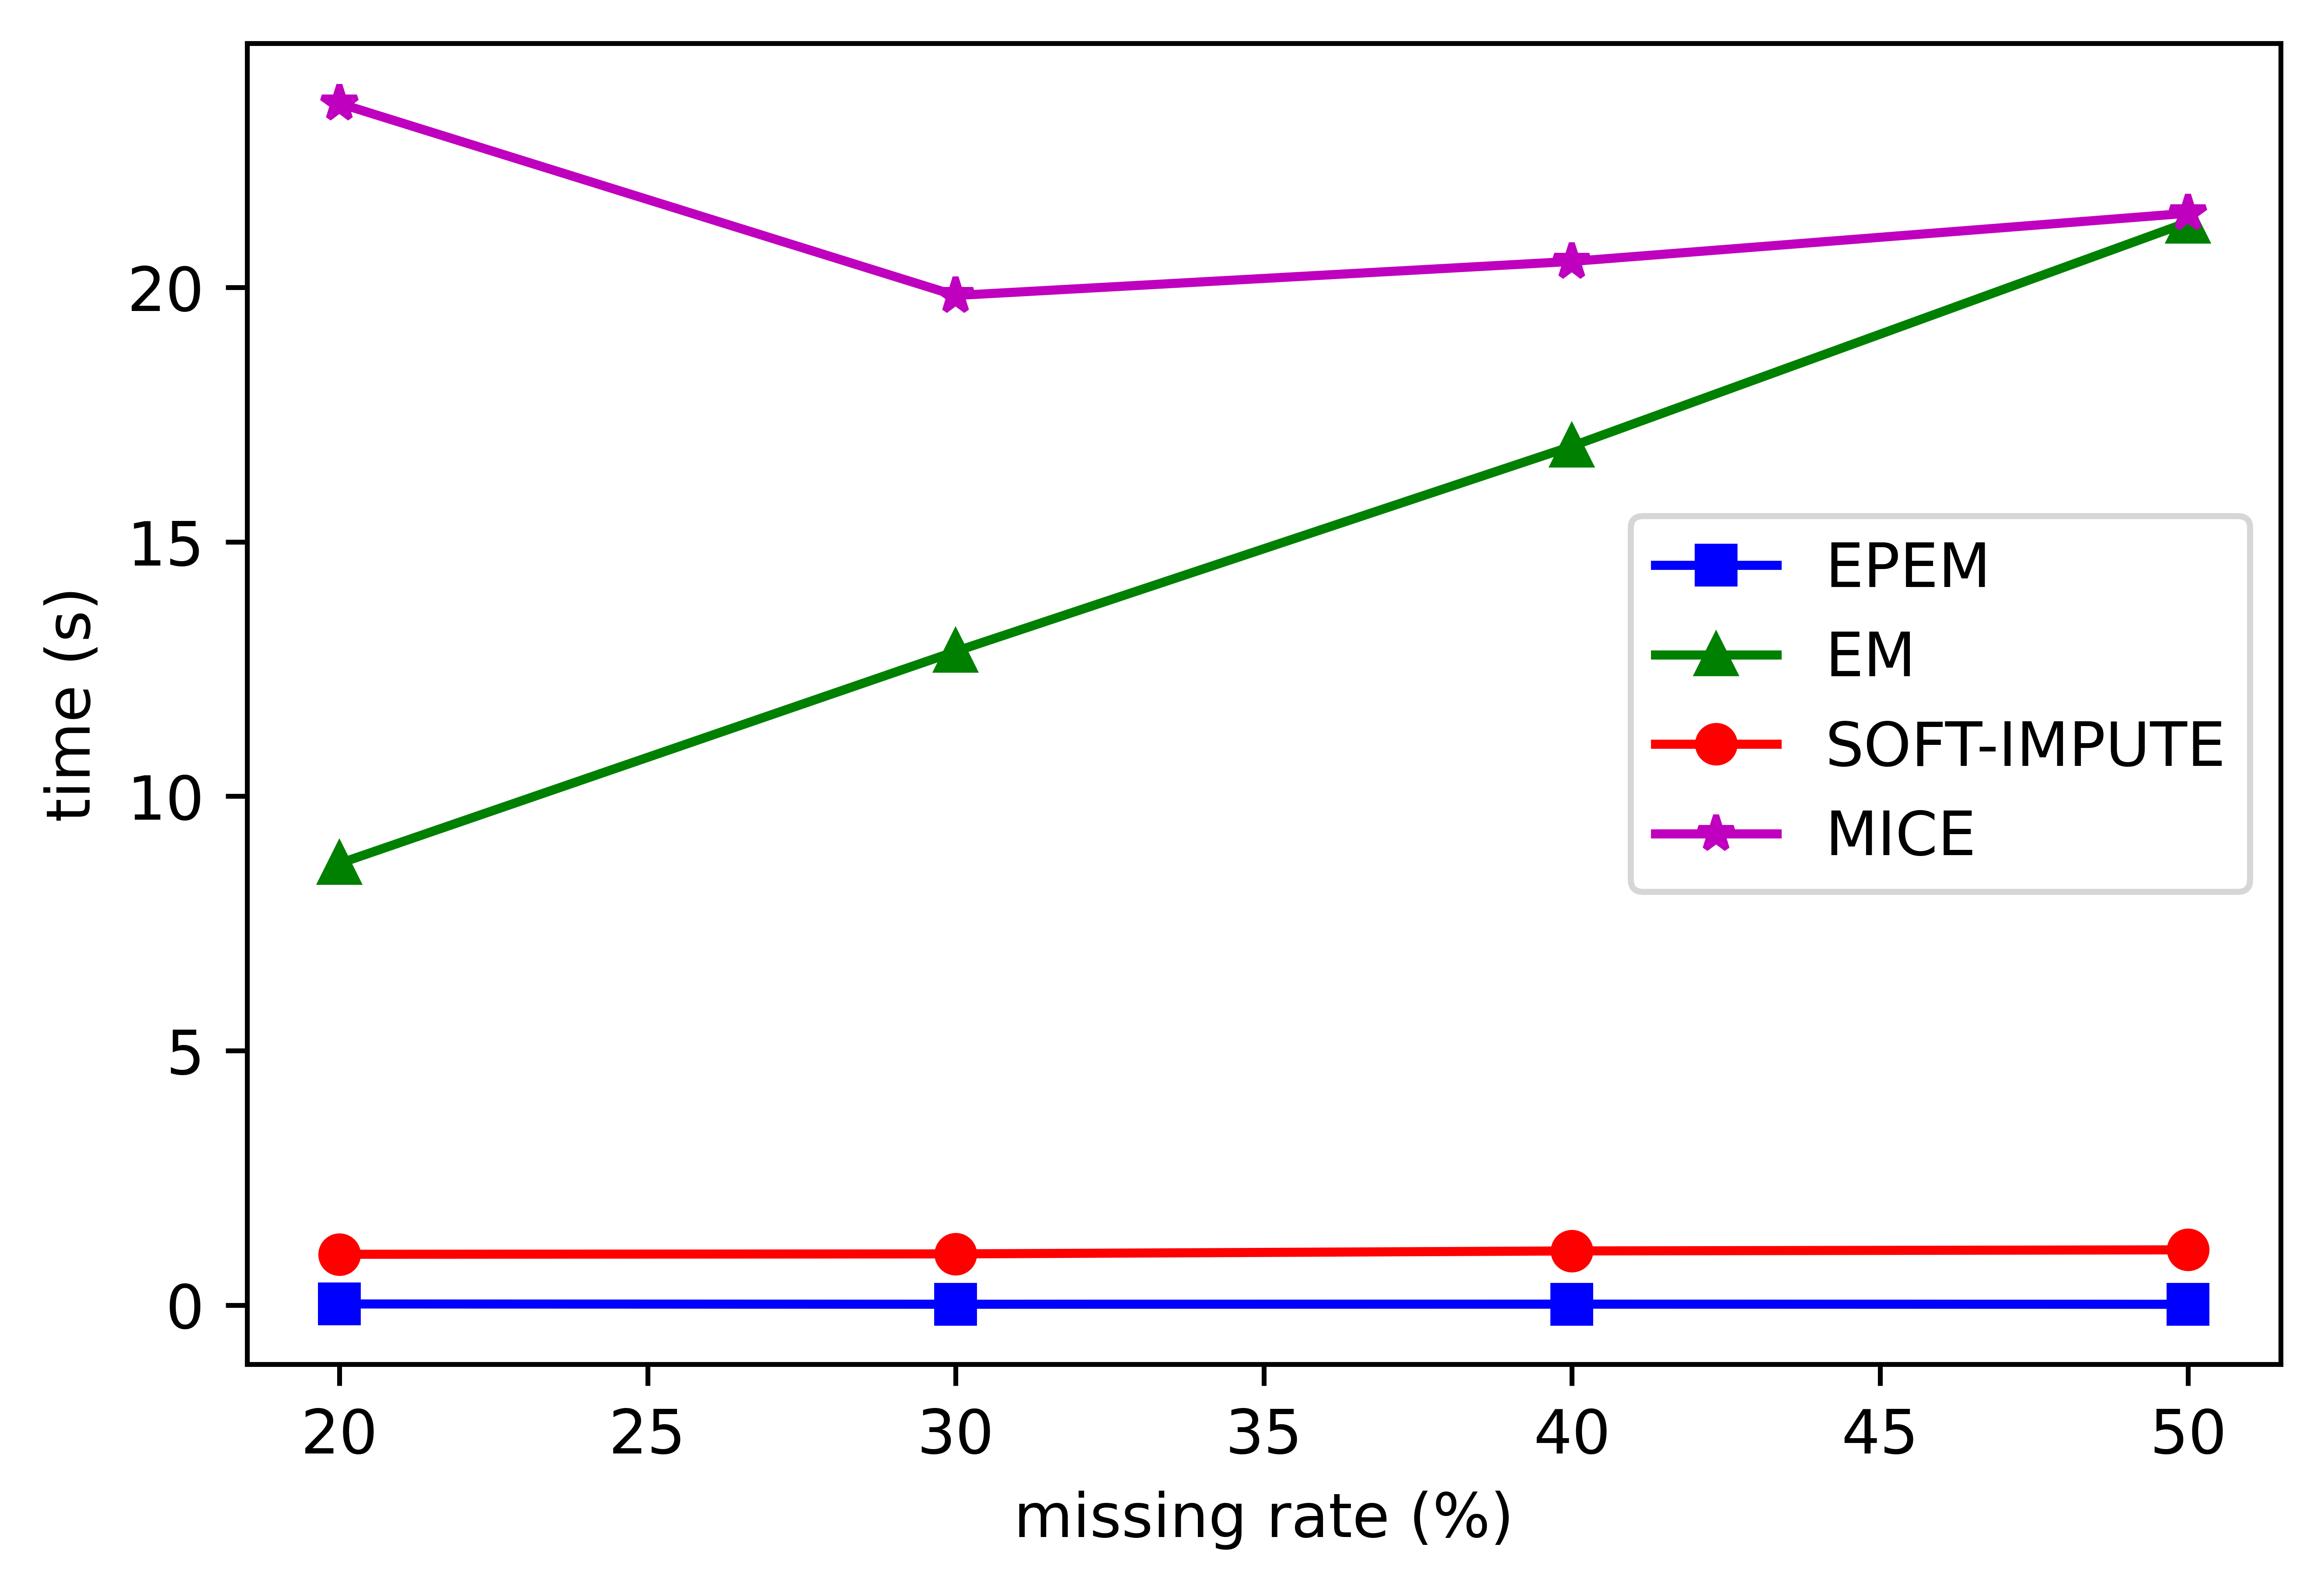

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.figure(dpi=1000)
plt.plot(eight_bl['rate'],eight_bl['EPEM'],'bs-')
plt.plot(eight_bl['rate'],eight_bl['EM'],'g^-')
plt.plot(eight_bl['rate'],eight_bl['SOFT-IMPUTE'],'ro-')
plt.plot(eight_bl['rate'],eight_bl['MICE'],'m*-')
plt.legend(['EPEM', 'EM', 'SOFT-IMPUTE', 'MICE'])
plt.xlabel('missing rate (%)')
plt.ylabel('time (s)')
plt.show()
plt.savefig('plot.png', dpi = 1000)

In [ ]:
from google.colab import files
files.download('plot.png')